# Modelo de ML: Rede Neural LSTM

## Configurações iniciais

In [49]:
# Importações de libraries importantes
import pandas as pd
import numpy as np
import pickle as pl
import tensorflow as tf
import datetime
import tensorflow.keras
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import pickle as pl
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Bidirectional, RepeatVector, Permute, Reshape, LSTM, Multiply, Lambda, Embedding, Dense, Dropout, Multiply, Concatenate, Flatten

In [50]:
# Carregamento de datasets processados
X_train = pl.load(open('../data/processed/X_train.pkl', 'rb'))
X_train_deploy = pl.load(open('../data/processed/X_train_deploy.pkl', 'rb'))
X_test = pl.load(open('../data/processed/X_test.pkl', 'rb'))
Y_train = pl.load(open('../data/processed/Y_train.pkl', 'rb'))
Y_test = pl.load(open('../data/processed/Y_test.pkl', 'rb'))

## Construção do Modelo

### Camadas de Entrada

In [51]:
dimensao_embedding = 32
tamanho_frases = 400
vocabulario_tamanho = 178800

# Camada de entrada
inputs = Input(shape=(tamanho_frases, ))

# Camada de embedding que transforma as sequências em vetores densos
embedding = Embedding(vocabulario_tamanho, dimensao_embedding, input_length=tamanho_frases)(inputs)

### Camadas Escondidas

In [52]:
# Camada LSTM bidirecional para poder relembrar tanto passado --> futuro quanto futuro --> passado

neuronios = 32
lstm = Bidirectional(LSTM(neuronios, return_sequences=True))(embedding)

# Camada dropout

dropout = Dropout(0.1)


# Mecanismo de atenção

attention_weights = Dense(1, activation='tanh')(lstm)
attention_weights = Flatten()(attention_weights)
attention_weights = Activation('softmax')(attention_weights)
attention_weights = RepeatVector(neuronios*2)(attention_weights)
attention_weights = Permute([2, 1])(attention_weights)
attention_weights = Reshape((tamanho_frases, neuronios*2))(attention_weights)
attention_output = Multiply()([lstm, attention_weights])
attention_output = Lambda(lambda x: K.sum(x, axis=1))(attention_output)

### Camadas de Saída

In [53]:
# Camada densa que passa a saída (output)
output = Dense(16, activation='relu')(attention_output)
output = Dense(1, activation='sigmoid')(output)

## Sumário do Modelo

In [54]:
modelo = Model(inputs=inputs, outputs=output)
modelo.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 400)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 400, 32)      5721600     ['input_3[0][0]']                
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 400, 64)     16640       ['embedding_2[0][0]']            
 )                                                                                                
                                                                                                  
 dense_6 (Dense)                (None, 400, 1)       65          ['bidirectional_2[0][0]']  

## Compilação e Treinamento do Modelo 

In [55]:
modelo.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [56]:
now = datetime.datetime.now()
modelo_ = modelo.fit(X_train, Y_train, epochs=4, validation_data=(X_test, Y_test), verbose=3, batch_size=5)

now2 = datetime.datetime.now()
time = now2 - now

print(f"O tempo que levou para treinar é de {time}")

Epoch 1/4
Epoch 2/4
Epoch 3/4
Epoch 4/4
O tempo que levou para treinar é de 6:52:46.793141


## Avaliação do Modelo

In [57]:
history = pd.DataFrame(modelo_.history)
history

,loss,accuracy,val_loss,val_accuracy
0,0.390770,0.814847,0.283109,0.882844
1,0.179320,0.929517,0.245641,0.898479
2,0.102288,0.959996,0.254663,0.900693
3,0.063431,0.973641,0.320283,0.898479


In [58]:
y_pred = modelo.predict(X_test)
y_pred = np.array(list(map(lambda x: 1 if x > 0.5 else 0, y_pred)))
y_pred

438/438 [==============================] - 19s 37ms/step


array([0, 0, 0, ..., 0, 1, 1])

In [59]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      7162
           1       0.93      0.85      0.89      6845

    accuracy                           0.90     14007
   macro avg       0.90      0.90      0.90     14007
weighted avg       0.90      0.90      0.90     14007



In [60]:
def plotar_dados(titulo, train, val, ylabel):
    
    sns.set()
    ax, fig = plt.subplots(figsize=(8, 5))
    # Linhas de treinamento e teste
    fig.plot(history.index, history[train], label="Treinamento")
    fig.plot(history.index, history[val], label="Validação")
    #Títulos
    plt.xlabel("Épocas")
    plt.title(titulo)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

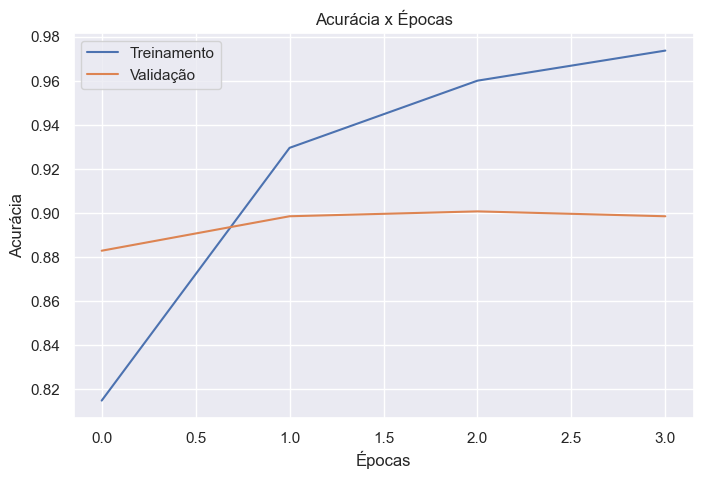

In [61]:
plotar_dados("Acurácia x Épocas", "accuracy", "val_accuracy", "Acurácia")

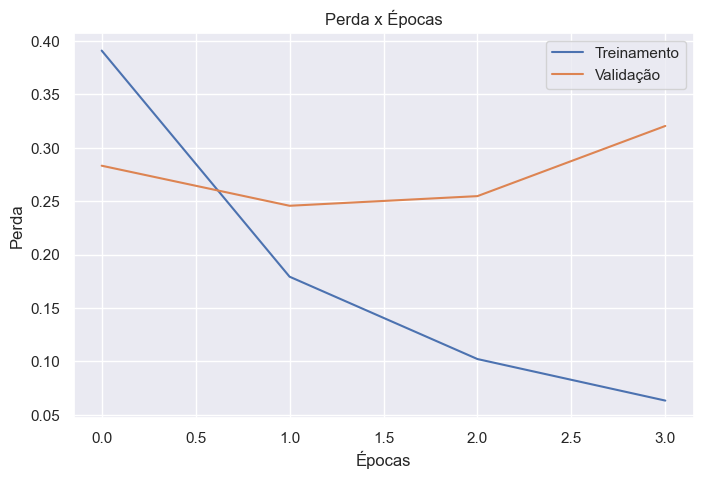

In [62]:
plotar_dados("Perda x Épocas", "loss", "val_loss", "Perda")

## Avaliação Prática 

In [65]:
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def prep_dados(texto: str):
    
    # Limpa o texto (remove alfanuméricos, simbolos, etc.)
    texto = re.sub(r'[^a-zA-Z0-9\s]', '', texto)
    texto = texto.lower()
    
    #Remove palavras desnecessárias
    stopwords_ = set(stopwords.words('english'))
    ma = lambda x: ' '.join([word for word in x.split() if word not in (stopwords_)])
    dados_prep = ma(texto)
    
    # Lematiza o texto (pega somente a raiz das palavras)
    tokenizador = nltk.tokenize.WhitespaceTokenizer()
    lematizador = nltk.stem.WordNetLemmatizer()
        
    st = ""
        
    for palavra in tokenizador.tokenize(dados_prep):
        st = st + lematizador.lemmatize(palavra) + " "
    
    
    # Tranforma em array do numpy
    dados_prep = np.array([dados_prep])
    
    # Tokeniza
 
    oov_tok = "<OOV>"
    tokenizador = Tokenizer(oov_token=oov_tok)
    tokenizador.fit_on_texts(X_train_deploy)
    dados_prep = tokenizador.texts_to_sequences(dados_prep)
    
    # Padding para adequar o tamanho da sequência
    tamanho_frases = 400
    dados_prep = pad_sequences(dados_prep, maxlen=tamanho_frases, padding='post', truncating='post')
    
    return dados_prep
    

In [70]:
negativo = prep_dados("I was really disappointed in this movie. The acting was wooden and uninspired, the pacing was slow, and the dialogue felt forced. Definitely not worth the ticket price.")
positivo = prep_dados("I thought this movie was pretty good. The cinematography was beautiful, the acting was solid, and the storyline was intriguing. It's not my favorite movie ever, but I enjoyed it.")
neutro = prep_dados("not Bad It was normal, I liked it partially!!!!!!")

print(f"O valor da predição para a frase negativa é: {modelo.predict(negativo)[0][0]}")
print(f"O valor da predição para a frase positiva é: {modelo.predict(positivo)[0][0]}")
print(f"O valor da predição para a frase neutra é: {modelo.predict(neutro)[0][0]}")

1/1 [==============================] - 1s 687ms/step
O valor da predição para a frase negativa é: 0.0010001284535974264
1/1 [==============================] - 1s 642ms/step
O valor da predição para a frase positiva é: 0.9746255874633789
1/1 [==============================] - 1s 620ms/step
O valor da predição para a frase neutra é: 0.42375609278678894


## Armazenamento do Modelo 

In [71]:
# Formato h5
modelo.save("../models/modelo.h5")
# Formato pickle
pl.dump(modelo, open('../models/modelo.pkl', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\activation
......vars
...layers\bidirectional
......vars
...layers\bidirectional\backward_layer
......vars
...layers\bidirectional\backward_layer\cell
......vars
.........0
.........1
.........2
...layers\bidirectional\forward_layer
......vars
...layers\bidirectional\forward_layer\cell
......vars
.........0
.........1
.........2
...layers\bidirectional\layer
......vars
...layers\bidirectional\layer\cell
......vars
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\embedding
......vars
.........0
...layers\flatten
......vars
...layers\input_layer
......vars
...layers\lambda
......vars
...layers\multiply
......vars
...layers\permute
......vars
...layers\repeat_vector
......vars
...layers\reshape
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........